In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import os



In [ ]:
df = pd.read_csv('Data\multi_feature_sales_data.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date',inplace=True)


In [2]:
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.001):
            self.model.stop_training = True

In [3]:

def create_df(file):
    df = pd.read_csv(file,)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    return df

def segment_df(df, start_date: str, end_date: str):        
    data = df.loc[start_date:end_date]
    return data    


def resample_data(df, size: str):               # size will will specify weekly or monthly
    data = df.resample(size).agg({'Sales':'sum', 'Dollar to Pkr':'mean', 'Daily Cases':'sum'})
    return data

def resample_stock_data(df: pd.DataFrame):
    
    df_temp = df.copy(deep=True)

    df_temp.drop('Sales', inplace=True, axis=1)

    df_temp.drop('Average Discount', inplace=True, axis=1)
    df_temp.drop('Day', inplace=True, axis=1)
    df_temp.drop('Week Day', inplace=True, axis=1)
    df_temp.drop('Week End', inplace=True, axis=1)
    df_temp.drop('Hijri Dates', inplace=True, axis=1)

    # df_temp['Date'] = pd.to_datetime(df_temp['Date'], format="%Y-%m-%d")
    # df_temp.set_index('Date', inplace=True)
    df_temp = df_temp.resample('M').sum()

    for index, row in df_temp.iterrows():
        df_temp.loc[index, 'Year'] = index.year
        df_temp.loc[index, 'Month'] = index.month
        df_temp.loc[index, 'eid ul fitr'] = row['eid ul fitr']/30
        df_temp.loc[index, 'eid ul Adha'] = row['eid ul Adha']/30
        df_temp.loc[index, 'Muharrum'] = row['Muharrum']/30
        df_temp.loc[index, 'Wheat Harvest'] = row['Wheat Harvest']/30
        df_temp.loc[index, 'Cotton Harvest'] = row['Cotton Harvest']/30

    return df_temp

def moving_average(df, window_size, column_name, new_column_name):
    data = df
    data[new_column_name] = data[column_name].rolling(window=window_size).mean()
    return data

def view_df(df, head: bool=False, tail: bool=False):
    if head == False and tail == False:
        print(df)
    elif head == True:
        print(df.head(10))
    else:
        print(df.tail(10))

def line_plot(df, columns: list, color):
    for c in columns:
        plt.plot(df.index, df[c], color = color)
        plt.scatter(df.index, df[c], color = color)
        plt.show()

def replace_missing(df):
    data = df
    for column in data:
        data[column].interpolate(inplace = True)
    return data

def train_test_split(df, split):
    train_size = int(len(df)*split)
    train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]
    return train_dataset, test_dataset

def create_X_Y_train(training_df, testing_df, target_variable):
    X_train = training_df.drop(target_variable, axis = 1)
    y_train = training_df.loc[:,target_variable]
    
    X_test = testing_df.drop(target_variable, axis = 1)
    y_test = testing_df.loc[:,target_variable]

    return X_train, y_train, X_test, y_test

def scale_and_transform(x_train, y_train, x_test, y_test):
    scaler_x = MinMaxScaler(feature_range = (0,1))
    scaler_y = MinMaxScaler(feature_range = (0,1))
    input_scaler = scaler_x.fit(x_train)
    output_scaler = scaler_y.fit(y_train)
    train_y_norm = output_scaler.transform(y_train)
    train_x_norm = input_scaler.transform(x_train)
    test_y_norm = output_scaler.transform(y_test)
    test_x_norm = input_scaler.transform(x_test)

    return scaler_x, scaler_y, train_x_norm, train_y_norm, test_x_norm, test_y_norm

def create_dataset (x_norm, y_norm, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(x_norm)-time_steps):
        v = x_norm[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y_norm[i+time_steps])
    return np.array(Xs), np.array(ys)

def create_model_bilstm(units, loss, x_train, target_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units, activation = 'relu',                          
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))  #
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))  #
    model.add(Bidirectional(LSTM(units = units, return_sequences = True)))  #
    model.add(Bidirectional(LSTM(units = units, activation = 'relu', return_sequences = True)))
    model.add(Bidirectional(LSTM(units = units, activation = 'relu')))
    model.add(Dense(target_size, activation='relu'))
    #Compile model
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    model.compile(loss=loss, optimizer='adam')
    return model

def create_model(model_name, units, loss, x_train, target_size):
    model = Sequential()
    model.add(model_name (units = units, activation = 'relu', return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(model_name (units = units, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = target_size, activation='relu'))
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
    logcosh = tf.keras.losses.LogCosh()
    #Compile model
    model.compile(loss=loss, optimizer='adam')
    return model


def fit_model(model, epochs, x_train, y_train):
    trainingStopCallback = haltCallback()
    # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
    #                                            patience = 10)
    history = model.fit(x_train, y_train, epochs = epochs,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False,callbacks = trainingStopCallback
                        )
    return history

def plot_loss (history, name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
    filename = 'loss ' + name
    plt.savefig(filename)
    # plt.show()

def inverse_transformation(scaler_y, y_train:np.ndarray, y_test:np.ndarray):
    y_test = scaler_y.inverse_transform(y_test)
    y_train = scaler_y.inverse_transform(y_train)
    return y_train, y_test

def model_fitting(model, x_train, scaler_y):

    fitting = model.predict(x_train)
    return scaler_y.inverse_transform(fitting)

def plot_fit(fit, y_train, name, column_name, epochs):
    plt.figure(figsize=(10, 6))
    range_future = len(fit)
    plt.plot(np.arange(range_future), np.array(y_train), 
             label='Training Data')     
    plt.plot(np.arange(range_future),np.array(fit),
            label='Model Fit ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title(column_name)
    filename = column_name + ' model fitting ' + str(epochs)
    # plt.savefig(filename)
    plt.show()

def prediction(model, x_test, scaler_y):
    prediction = model.predict(x_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

def plot_future(prediction, y_test, name, column_name, epochs):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test Data')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Sales')
    plt.title(column_name)
    filename = column_name + ' prediction ' + str(epochs)
    # plt.savefig(filename)
    plt.show()

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


In [ ]:
# file = 'sample.csv'
# data = create_df(file)
# view_df(data)    

In [5]:
# data.drop('Sales', inplace=True, axis=1)
# data.drop('Average Discount', inplace=True, axis=1)

In [6]:
# ax = sns.heatmap(data.corr(), vmin=0, vmax=1)

In [7]:
# data = replace_missing(data)
# data = resample_stock_data(data)

# ax = sns.heatmap(data.corr(), vmin=0, vmax=1)

In [8]:
# data.drop('Muharrum', inplace=True, axis=1)

In [6]:
directory = 'Working Data/Stocks/Monthly_Stocks_Data'
for filename in os.listdir(directory):
    
    print(filename)
    file = directory + '/' + filename
    data = create_df(file)
    # view_df(data)

    training_df, testing_df = train_test_split(data, 0.8)

    target_brands = []
    for column in data.columns:
        if "brand" in column:
            target_brands.append(column)
    x_train, y_train, x_test, y_test = create_X_Y_train(training_df, testing_df, target_brands)
    scaler_x, scaler_y, train_x_norm, train_y_norm, test_x_norm, test_y_norm = scale_and_transform(x_train, y_train, x_test, y_test)

    TIME_STEPS = 3
    x_test_3d, y_test_3d = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
    x_train_3d, y_train_3d = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)

    model_bilstm = create_model_bilstm(128, 'huber_loss', x_train_3d, len(target_brands))
    model_lstm = create_model(LSTM, 128, 'huber_loss', x_train_3d, len(target_brands))

    epochs = 3

    history_bilstm = fit_model(model_bilstm, epochs , x_train_3d, y_train_3d)
    history_lstm = fit_model(model_lstm, epochs, x_train_3d, y_train_3d)

    # plot_loss (history_bilstm, 'BILSTM')
    # plot_loss (history_lstm, 'LSTM')


category a228a-fix with features.csv
Epoch 1/3
2/2 [==============================] - 19s 3s/step - loss: 0.0529 - val_loss: 0.0446
Epoch 2/3
2/2 [==============================] - 0s 73ms/step - loss: 0.0522 - val_loss: 0.0442
Epoch 3/3
2/2 [==============================] - 0s 56ms/step - loss: 0.0513 - val_loss: 0.0438
Epoch 1/3
2/2 [==============================] - 7s 731ms/step - loss: 0.0529 - val_loss: 0.0444
Epoch 2/3
2/2 [==============================] - 0s 44ms/step - loss: 0.0520 - val_loss: 0.0436
Epoch 3/3
2/2 [==============================] - 0s 46ms/step - loss: 0.0511 - val_loss: 0.0428
category B9q-fix with features.csv
Epoch 1/3
2/2 [==============================] - 17s 3s/step - loss: 0.0292 - val_loss: 0.0225
Epoch 2/3
2/2 [==============================] - 0s 73ms/step - loss: 0.0288 - val_loss: 0.0222
Epoch 3/3
2/2 [==============================] - 0s 86ms/step - loss: 0.0284 - val_loss: 0.0218
Epoch 1/3
2/2 [==============================] - 7s 1s/step - los

In [10]:
target_brands = []
for c in data.columns:
    if 'brand' in c:
        target_brands.append(c)

target_brands_train = [c + ' train' for c in target_brands]
target_brands_test = [c + ' test' for c in target_brands]
target_brands_actual = [c + ' actual' for c in target_brands]

In [11]:
y_train, y_test = inverse_transformation(scaler_y, y_train_3d, y_test_3d)

bilstm_fit = model_fitting(model_bilstm, x_train_3d, scaler_y)
lstm_fit = model_fitting(model_lstm, x_train_3d, scaler_y)

df_train_bilstm = pd.DataFrame(bilstm_fit, columns= target_brands_train )
df_train_lstm = pd.DataFrame(lstm_fit, columns= target_brands_train)

df_y_train = pd.DataFrame(y_train, columns = target_brands_actual)

df_concat_train_bilstm = pd.concat([df_train_bilstm, df_y_train], axis=1)
df_concat_train_lstm = pd.concat([df_train_lstm, df_y_train], axis=1)

df_concat_train_bilstm.to_csv('sample file df_train_bilstm 100 epochs monthly.csv')
df_concat_train_lstm.to_csv('sample file df_train_lstm 100 epochs monthly.csv')

prediction_bilstm = prediction(model_bilstm, x_test_3d, scaler_y)
prediction_lstm = prediction(model_lstm, x_test_3d, scaler_y)

df_test_bilstm = pd.DataFrame(prediction_bilstm, columns= target_brands_test )
df_test_lstm = pd.DataFrame(prediction_lstm, columns= target_brands_test)

df_y_test = pd.DataFrame(y_test, columns = target_brands_actual)


df_concat_test_bilstm = pd.concat([df_test_bilstm, df_y_test], axis=1)
df_concat_test_lstm = pd.concat([df_test_lstm, df_y_test], axis=1)
    
df_concat_test_bilstm.to_csv('sample df_test_bilstm 100 epochs monthly.csv')
df_concat_test_lstm.to_csv('sample df_test_lstm 100 epochs monthly.csv')


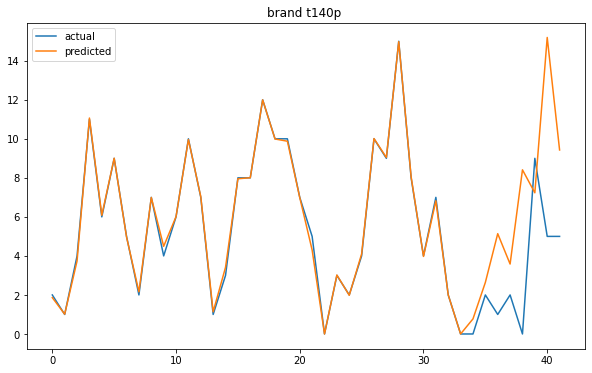

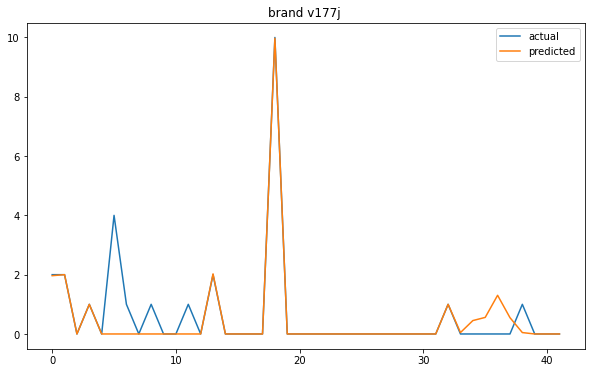

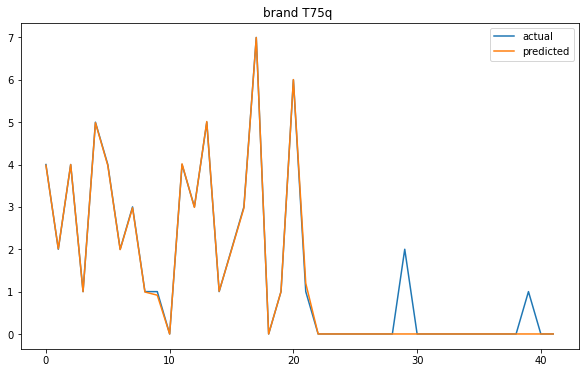

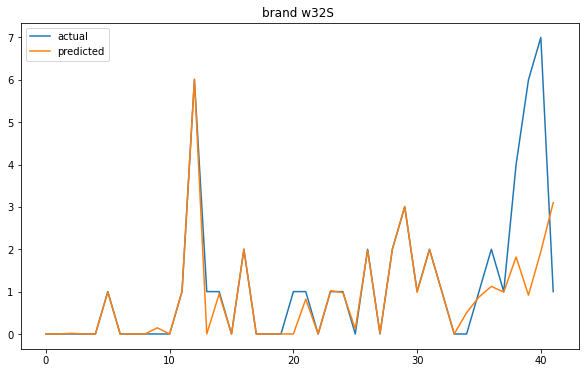

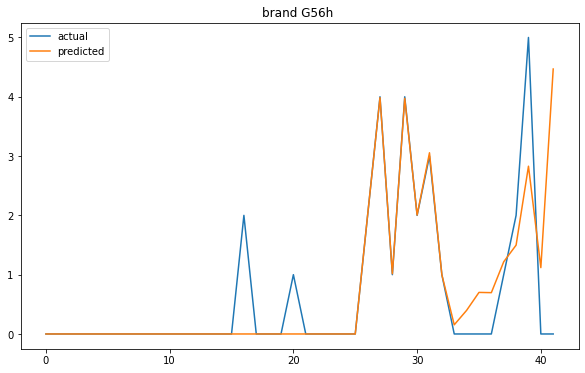

In [12]:
df_train_bilstm = pd.read_csv('sample file df_train_bilstm 100 epochs monthly.csv')
df_train_bilstm.drop('Unnamed: 0', inplace=True, axis=1)
for column in df_train_bilstm.columns:
    if 'train' not in column:

        actual_values = df_train_bilstm[column].tolist()
        test_column = column.replace('actual', '') + 'train'
        test_values = df_train_bilstm[test_column].tolist()
        plt.figure(figsize=(10,6))
        plt.plot(actual_values, label = 'actual')
        plt.plot(test_values, label = 'predicted')
        title = column.replace('actual', '')
        plt.title(title)
        plt.legend()
        plt.show()

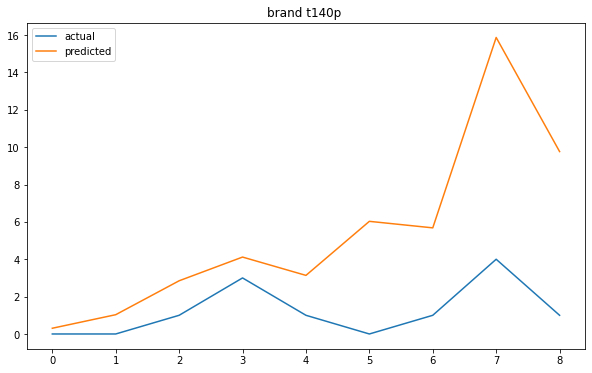

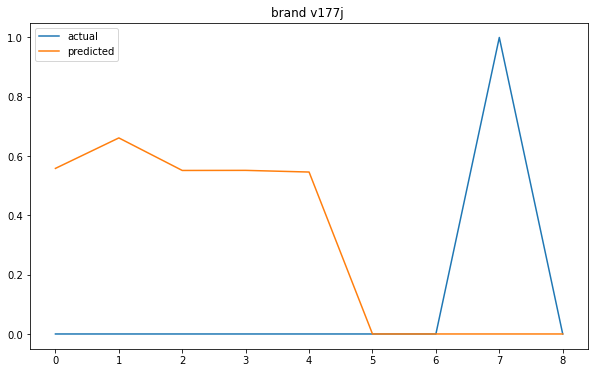

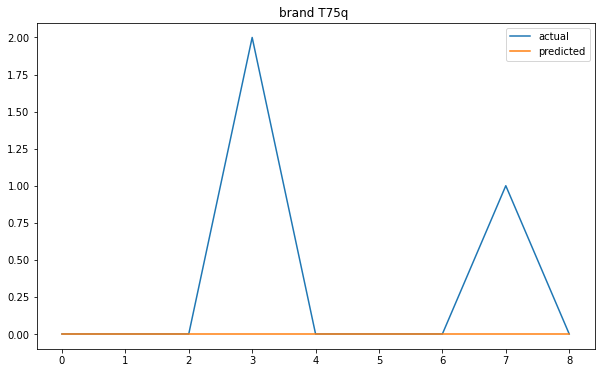

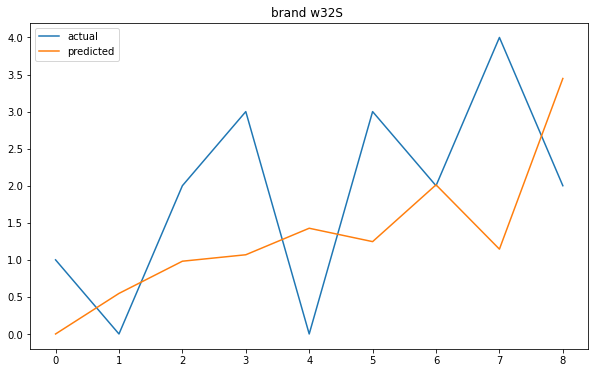

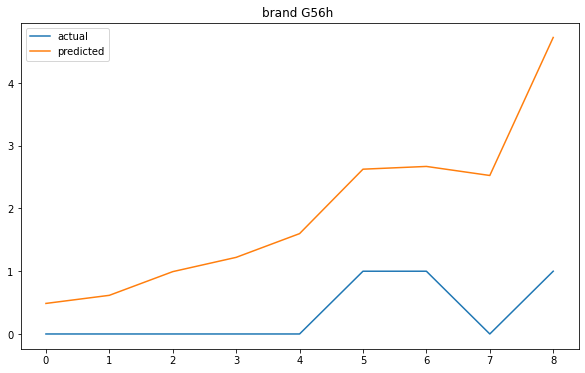

In [13]:
df_test_bilstm = pd.read_csv('sample df_test_bilstm 100 epochs monthly.csv')
df_test_bilstm.drop('Unnamed: 0', inplace=True, axis=1)
for column in df_test_bilstm.columns:
    if 'test' not in column:

        actual_values = df_test_bilstm[column].tolist()
        test_column = column.replace('actual', '') + 'test'
        test_values = df_test_bilstm[test_column].tolist()
        plt.figure(figsize=(10,6))
        plt.plot(actual_values, label = 'actual')
        plt.plot(test_values, label = 'predicted')
        title = column.replace('actual', '')
        plt.title(title)
        plt.legend()
        plt.show()
        

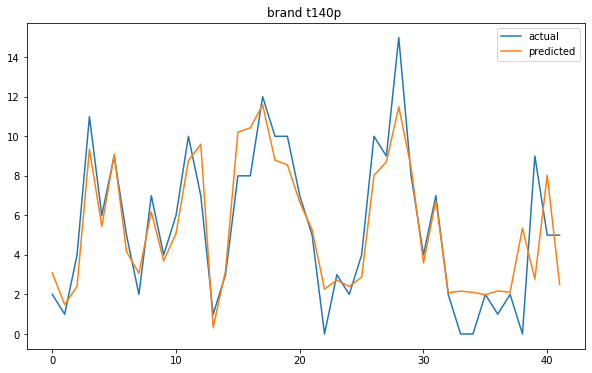

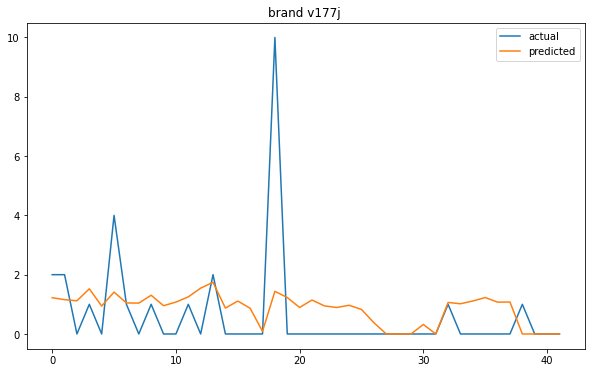

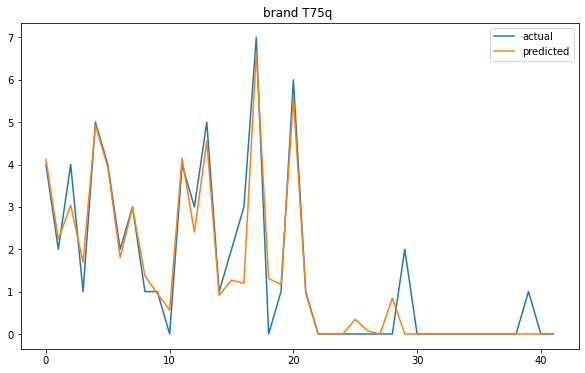

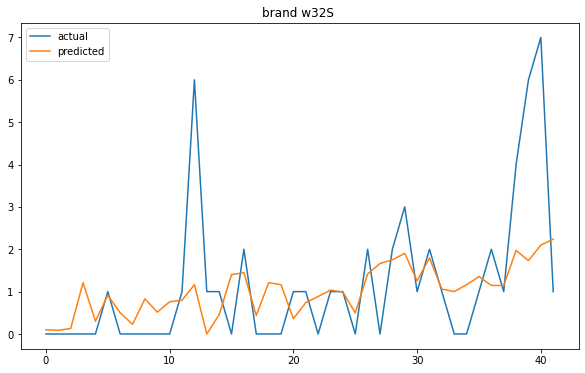

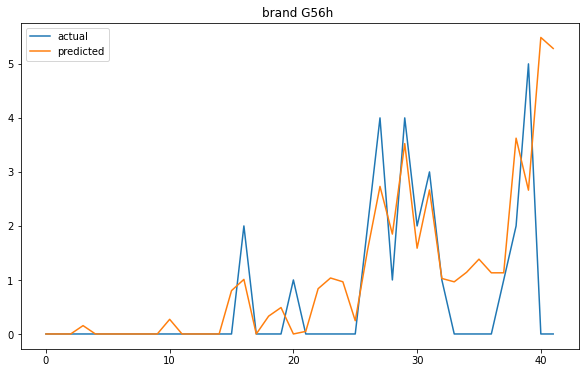

In [14]:
df_train_lstm = pd.read_csv('sample file df_train_lstm 100 epochs monthly.csv')
df_train_lstm.drop('Unnamed: 0', inplace=True, axis=1)
for column in df_train_lstm.columns:
    if 'train' not in column:

        actual_values = df_train_lstm[column].tolist()
        test_column = column.replace('actual', '') + 'train'
        test_values = df_train_lstm[test_column].tolist()
        plt.figure(figsize=(10,6))
        plt.plot(actual_values, label = 'actual')
        plt.plot(test_values, label = 'predicted')
        title = column.replace('actual', '')
        plt.title(title)
        plt.legend()
        plt.show()

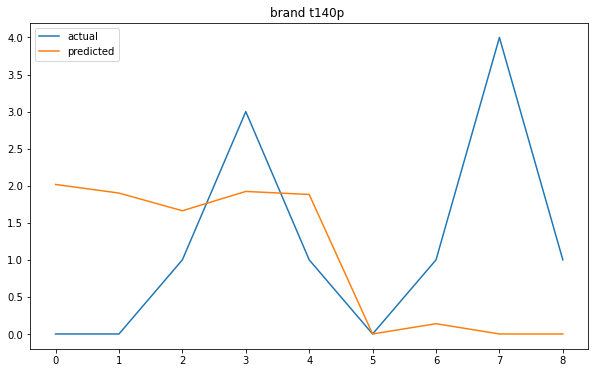

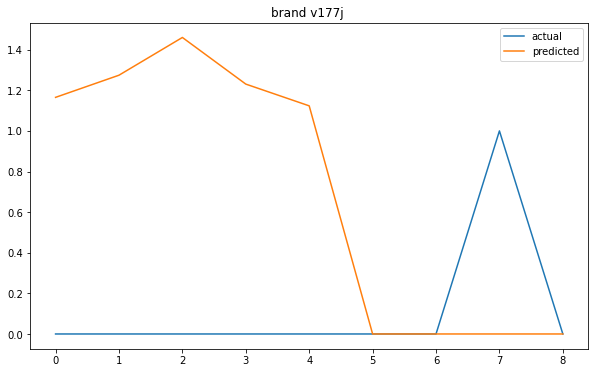

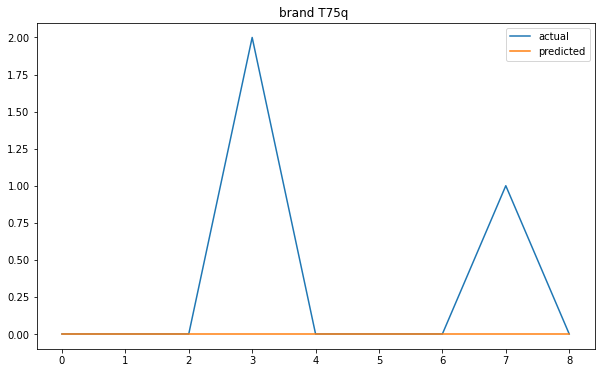

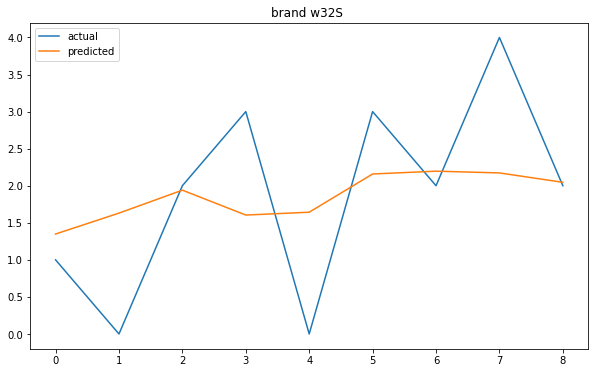

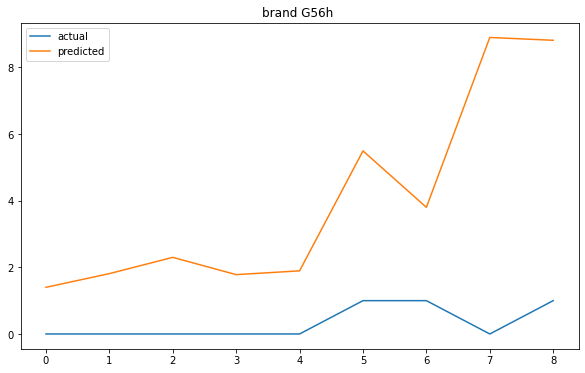

In [15]:
df_test_lstm = pd.read_csv('sample df_test_lstm 100 epochs monthly.csv')
df_test_lstm.drop('Unnamed: 0', inplace=True, axis=1)
for column in df_test_lstm.columns:
    if 'test' not in column:

        actual_values = df_test_lstm[column].tolist()
        test_column = column.replace('actual', '') + 'test'
        test_values = df_test_lstm[test_column].tolist()
        plt.figure(figsize=(10,6))
        plt.plot(actual_values, label = 'actual')
        plt.plot(test_values, label = 'predicted')
        title = column.replace('actual', '')
        plt.title(title)
        plt.legend()
        plt.show()
        